### Requirement Setup + Imports

In [ ]:
# !pip install diffusers transformers accelerate
# !pip install pillow numpy scipy tqdm matplotlib seaborn torchmetrics
# !pip install ipywidgets
# !pip install kaggle matplotlib

In [ ]:
# checking if data of 5k images is present
import os

len(os.listdir("data/ffhq/"))

5000

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
from pathlib import Path
from typing import Dict, List, Tuple, Optional
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt
from diffusers import StableDiffusionPipeline, UNet2DConditionModel, DDIMScheduler

### Setting up configuration
#### This helps in testing on different epochs, batch sizes
#### Also used in Ablation testing when playing with parameters - lambda_sparse, target_sparsity
##### we change these values and rerun the kernel to analyse trends and different results

In [ ]:
class Config:
    # creating a class for configuration - easier for Ablation testing afterwards

    data_dir = "./data/ffhq"
    output_dir = "./output_pruning_different_sparsity"


    batch_size = 2
    num_epochs = 10
    learning_rate = 1e-5
    lambda_sparse = 0.003
    gradient_accumulation_steps = 4
    target_sparsity = 0.1

    num_workers = 2
    resolution = 512

    # pre-trained model
    model_name = "runwayml/stable-diffusion-v1-5"

    device = "cuda" if torch.cuda.is_available() else "cpu"

    # creating output data
    Path(output_dir).mkdir(exist_ok=True, parents=True)

config = Config()

### Initial Setup
#### This includes defining classes for Dataset Training and Pruned UNet

In [ ]:
class FFHQDataset(Dataset):

    def __init__(self, data_dir: str, resolution: int = 512, split: str = "train"):
        self.data_dir = Path(data_dir)
        self.resolution = resolution
        self.split = split

        # finding all image formats
        self.image_paths = []
        for ext in ['*.png', '*.jpg', '*.jpeg']:
            self.image_paths.extend(list(self.data_dir.glob(ext)))

        # splittng the dataset - 90% train, 10% val
        n_train = int(len(self.image_paths) * 0.9)
        if split == "train":
            self.image_paths = self.image_paths[:n_train]
        else:
            self.image_paths = self.image_paths[n_train:]

        # Transforms
        self.transform = transforms.Compose([
            transforms.Resize(resolution),
            transforms.CenterCrop(resolution),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])

        print(f"Loading Completed - Found {len(self.image_paths)} images for {split} split")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)
        return {"pixel_values": image}

# loading the data
train_dataset = FFHQDataset(config.data_dir, config.resolution, "train")
val_dataset = FFHQDataset(config.data_dir, config.resolution, "val")

Loading Completed - Found 4500 images for train split
Loading Completed - Found 500 images for val split


In [ ]:
class ChannelImportancePredictor(nn.Module):
    # this class basically predicts the per channel importance

    def __init__(self, num_channels: int, timestep_embed_dim: int = 1280):
        super().__init__()
        self.num_channels = num_channels

        self.importance_net = nn.Sequential(
            nn.Linear(2 + timestep_embed_dim, 256),
            nn.SiLU(),
            nn.Dropout(0.1),
            nn.Linear(256, 128),
            nn.SiLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x: torch.Tensor, t_emb: torch.Tensor) -> torch.Tensor:
        B, C, H, W = x.shape

        mu_c = x.mean(dim=(2, 3))
        sigma_c = x.std(dim=(2, 3))

        t_emb_expanded = t_emb.unsqueeze(1).expand(-1, C, -1)

        # concatenating features
        features = torch.cat([
            mu_c.unsqueeze(2),
            sigma_c.unsqueeze(2),
            t_emb_expanded
        ], dim=2)

        # predicting the importance
        importance_scores = self.importance_net(features).squeeze(-1)
        return importance_scores

In [ ]:
class LearnedChannelPruningLayer(nn.Module):
    # this class contains the channel pruning process

    def __init__(self, num_channels: int, timestep_embed_dim: int = 1280,
                 target_sparsity: float = 0.3, temperature: float = 1.0):
        super().__init__()
        self.num_channels = num_channels
        self.target_sparsity = target_sparsity
        self.temperature = temperature

        self.importance_predictor = ChannelImportancePredictor(
            num_channels, timestep_embed_dim
        )

    def forward(self, x: torch.Tensor, t_emb: torch.Tensor):
        importance_scores = self.importance_predictor(x, t_emb)

        # finding threshold
        k = int(self.num_channels * (1 - self.target_sparsity))
        topk_values, _ = torch.topk(importance_scores, k, dim=1)
        threshold = topk_values[:, -1:].detach()

        # gradients softmax
        soft_mask = torch.sigmoid((importance_scores - threshold) / self.temperature)
        hard_mask = (importance_scores >= threshold).float()

        mask = hard_mask.detach() - soft_mask.detach() + soft_mask
        mask = mask.unsqueeze(2).unsqueeze(3)

        x_pruned = x * mask
        return x_pruned, mask, importance_scores

In [ ]:
class PrunedUNet2DConditionModel(nn.Module):

    def __init__(self, original_unet, target_sparsity=0.3):
        super().__init__()
        self.unet = original_unet
        self.config = original_unet.config

        # single pruning layer for mid_block (1280 channels)
        self.pruning_layer = LearnedChannelPruningLayer(
            num_channels=1280,
            timestep_embed_dim=1280,
            target_sparsity=target_sparsity
        )

        self.target_sparsity = target_sparsity
        self.pruning_enabled = True
        self.pruning_mask = None
        self.importance_scores = None

        pruning_params = sum(p.numel() for p in self.pruning_layer.parameters())

    def enable_pruning(self):
        # turn on pruning
        self.pruning_enabled = True

    def disable_pruning(self):
        # turn off pruning - for baseline evaluation
        self.pruning_enabled = False

    def parameters(self):
        # to return params
        return list(self.unet.parameters()) + list(self.pruning_layer.parameters())

    def train(self, mode=True):
        self.training = mode
        self.unet.train(mode)
        self.pruning_layer.train(mode)
        return self

    def eval(self):
        # to turn on evaluation mode
        return self.train(False)

    def forward(self, sample, timestep, encoder_hidden_states, return_dict=True, **kwargs):
        # forwards pass
        # ips -> down blocks -> middle block where pruning is applied -> pruned blocks
        # these pruned blocks -> up blocks -> final output

        # reset
        self.pruning_mask = None
        self.importance_scores = None


        if not torch.is_tensor(timestep):
            timestep = torch.tensor([timestep], dtype=torch.long, device=sample.device)
        elif timestep.ndim == 0:
            timestep = timestep.unsqueeze(0)

        # to get time stamp embeddings
        t_emb = self.unet.time_proj(timestep)
        t_emb = t_emb.to(dtype=sample.dtype)
        t_emb = self.unet.time_embedding(t_emb)

        # storing original mid block
        original_forward = self.unet.mid_block.forward
        wrapper_self = self

        # wrapper for pruning
        def pruned_forward(hidden_states, temb, *args, **kwargs):
            # applying pruning to original mid block
            result = original_forward(hidden_states, temb, *args, **kwargs)

            if wrapper_self.pruning_enabled:
                result, mask, scores = wrapper_self.pruning_layer(result, temb)
                wrapper_self.pruning_mask = mask
                wrapper_self.importance_scores = scores

            return result


        self.unet.mid_block.forward = pruned_forward

        try:
            output = self.unet(
                sample,
                timestep,
                encoder_hidden_states,
                return_dict=return_dict,
                **kwargs
            )
        finally:
            self.unet.mid_block.forward = original_forward

        return output

    def get_sparsity_loss(self):
        # calculating sparsity regularization loss
        # this encourages the model to use importance scores effectively
        if self.importance_scores is None:
            device = next(self.pruning_layer.parameters()).device
            return torch.tensor(0.0, device=device)

        # Mean importance score (lower = more channels pruned)
        return self.importance_scores.mean()

    def get_avg_sparsity(self):
        # calculate actual sparsity
        if self.pruning_mask is None:
            return 0.0

        # counting zeroes in mask
        return (self.pruning_mask == 0).float().mean().item()

### Loading Baseline Model + Integrating Pruning

In [ ]:
pipeline = StableDiffusionPipeline.from_pretrained(
    config.model_name, torch_dtype = torch.float32, safety_checker = None).to(config.device)

# extracting req. components
vae = pipeline.vae
text_encoder = pipeline.text_encoder
tokenizer = pipeline.tokenizer
scheduler = DDIMScheduler.from_config(pipeline.scheduler.config)
unet_baseline = pipeline.unet

# freezing VAE and text encoder
vae.requires_grad_(False)
text_encoder.requires_grad_(False)
vae.eval()
text_encoder.eval()

# creating pruned U-Net
unet_pruned = PrunedUNet2DConditionModel(unet_baseline, target_sparsity = config.target_sparsity).to(config.device)

# counting parameters
total_params = sum(p.numel() for p in unet_pruned.parameters())
pruning_params = sum(p.numel() for p in unet_pruned.pruning_layer.parameters())

print(f"Total parameters: {total_params}")
print(f"Pruning layer parameters: {pruning_params}")
print(f"Percentage trainable: {round(pruning_params/total_params*100, 2)}%")

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


Total parameters: 859882437
Pruning layer parameters: 361473
Percentage trainable: 0.04%


### Training Phase

In [ ]:
train_loader = DataLoader(
    train_dataset, batch_size = config.batch_size, shuffle = True, num_workers = config.num_workers, pin_memory = True)

val_loader = DataLoader(
    val_dataset, batch_size = config.batch_size, shuffle = False, num_workers = config.num_workers, pin_memory = True)

In [ ]:
def train_one_epoch(unet, vae, text_encoder, train_loader, optimizer,
                   scheduler_noise, lambda_sparse, gradient_accum_steps):

    unet.train()
    total_loss = 0
    total_denoising = 0
    total_sparsity_loss = 0
    total_sparsity_val = 0
    num_batches = 0

    optimizer.zero_grad()

    pbar = tqdm(train_loader, desc="Training", leave=True)
    for i, batch in enumerate(pbar):
        images = batch["pixel_values"].to(config.device)

        # encode to latent space
        with torch.no_grad():
            latents = vae.encode(images).latent_dist.sample()
            latents = latents * vae.config.scaling_factor

        # sampling noise and timesteps
        noise = torch.randn_like(latents)
        timesteps = torch.randint(
            0, scheduler_noise.config.num_train_timesteps,
            (latents.shape[0],), device=config.device
        ).long()

        # adding noise
        noisy_latents = scheduler_noise.add_noise(latents, noise, timesteps)

        with torch.no_grad():
            encoder_hidden_states = text_encoder(
                torch.zeros((latents.shape[0], 77),
                          dtype=torch.long, device=config.device)
            )[0]

        # predicting noise
        noise_pred = unet(noisy_latents, timesteps, encoder_hidden_states).sample

        # calculating losses
        denoising_loss = F.mse_loss(noise_pred, noise)
        sparsity_loss = unet.get_sparsity_loss()
        avg_sparsity = unet.get_avg_sparsity()

        loss = denoising_loss + lambda_sparse * sparsity_loss
        loss = loss / gradient_accum_steps


        loss.backward()

        # updating weights
        if (i + 1) % gradient_accum_steps == 0:
            torch.nn.utils.clip_grad_norm_(unet.parameters(), 1.0)
            optimizer.step()
            optimizer.zero_grad()

        # tracking metrics
        total_loss += loss.item() * gradient_accum_steps
        total_denoising += denoising_loss.item()
        total_sparsity_loss += (sparsity_loss.item() if isinstance(sparsity_loss, torch.Tensor)
                               else sparsity_loss)
        total_sparsity_val += avg_sparsity
        num_batches += 1

        # updating progress
        pbar.set_postfix({
            "loss": f"{round(total_loss/num_batches, 4)}",
            "sparsity": f"{round(total_sparsity_val/num_batches, 2)}%"
        })

    return {
        "loss": total_loss / num_batches,
        "denoising_loss": total_denoising / num_batches,
        "sparsity_loss": total_sparsity_loss / num_batches,
        "avg_sparsity": total_sparsity_val / num_batches
    }

In [ ]:
def validate(unet, vae, text_encoder, val_loader, scheduler_noise):
    # validating the model

    unet.eval()
    total_loss = 0
    num_batches = 0

    with torch.no_grad():
        pbar = tqdm(val_loader, desc="Validation", leave=True)
        for batch in pbar:
            images = batch["pixel_values"].to(config.device)

            latents = vae.encode(images).latent_dist.sample()
            latents = latents * vae.config.scaling_factor

            noise = torch.randn_like(latents)
            timesteps = torch.randint(
                0, scheduler_noise.config.num_train_timesteps,
                (latents.shape[0],), device=config.device
            ).long()

            noisy_latents = scheduler_noise.add_noise(latents, noise, timesteps)

            encoder_hidden_states = text_encoder(
                torch.zeros((latents.shape[0], 77),
                          dtype=torch.long, device=config.device)
            )[0]

            noise_pred = unet(noisy_latents, timesteps, encoder_hidden_states).sample
            loss = F.mse_loss(noise_pred, noise)

            total_loss += loss.item()
            num_batches += 1

            pbar.set_postfix({"val_loss": f"{round(total_loss/num_batches, 4)}"})

    return {"loss": total_loss / num_batches}

In [ ]:
# training pruning layers only
pruning_params = list(unet_pruned.pruning_layer.parameters())
optimizer = torch.optim.AdamW(pruning_params, lr=config.learning_rate)

# learning rate svheduler
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=config.num_epochs * len(train_loader)
)

train_history = {"loss": [], "sparsity": []}
val_history = {"loss": []}

print(f"Optimizer: AdamW with {len(pruning_params)} parameter groups")
print(f"Learning rate: {config.learning_rate}")
print(f"Epochs: {config.num_epochs}")

Optimizer: AdamW with 6 parameter groups
Learning rate: 1e-05
Epochs: 10


In [ ]:
# cleaning up the memory st training does not get interrupted
import gc
torch.cuda.empty_cache()
gc.collect()

88

In [ ]:
# training

best_val_loss = float("inf")

for epoch in range(config.num_epochs):
    print(f"Epoch {epoch+1}/{config.num_epochs}")
    print("\n")

    train_metrics = train_one_epoch(
        unet_pruned, vae, text_encoder, train_loader,
        optimizer, scheduler, config.lambda_sparse,
        config.gradient_accumulation_steps
    )

    # validation
    val_metrics = validate(
        unet_pruned, vae, text_encoder, val_loader, scheduler
    )

    train_history["loss"].append(train_metrics["loss"])
    train_history["sparsity"].append(train_metrics["avg_sparsity"])
    val_history["loss"].append(val_metrics["loss"])

    # saving theh best model - based on min. val loss
    if val_metrics["loss"] < best_val_loss:
        best_val_loss = val_metrics["loss"]
        checkpoint_path = Path(config.output_dir) / "checkpoint_best.pt"
        torch.save({
            "epoch": epoch,
            "model_state_dict": unet_pruned.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "train_loss": train_metrics["loss"],
            "val_loss": val_metrics["loss"],
        }, checkpoint_path)

    lr_scheduler.step()

Epoch 1/10




Training:   0%|          | 0/2250 [00:00<?, ?it/s]

Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 2/10




Training:   0%|          | 0/2250 [00:00<?, ?it/s]

Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 3/10




Training:   0%|          | 0/2250 [00:00<?, ?it/s]

Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 4/10




Training:   0%|          | 0/2250 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ecfefdd1870><function _MultiProcessingDataLoaderIter.__del__ at 0x7ecfefdd1870>

Exception ignored in: Traceback (most recent call last):
Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7ecfefdd1870>  File "/venv/main/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/venv/main/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7ecfefdd1870>
    
    Traceback (most recent call last):
self._shutdown_workers()self._shutdown_workers()Traceback (most recent call last):
  File "/venv/main/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__


  File "/venv/main/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/venv/main/lib/python3

Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 5/10




Training:   0%|          | 0/2250 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ecfefdd1870>
Traceback (most recent call last):
  File "/venv/main/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    Exception ignored in: self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x7ecfefdd1870>

  File "/venv/main/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
Traceback (most recent call last):
      File "/venv/main/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
if w.is_alive():  File "/venv/main/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers

  File "/venv/main/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
  File "/venv/main/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
AssertionError    : assert self._parent_pid == os.getpid(), 'can only test a child process'can onl

Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 6/10




Training:   0%|          | 0/2250 [00:00<?, ?it/s]

Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 7/10




Training:   0%|          | 0/2250 [00:00<?, ?it/s]

Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 8/10




Training:   0%|          | 0/2250 [00:00<?, ?it/s]

Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 9/10




Training:   0%|          | 0/2250 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ecfefdd1870>
Traceback (most recent call last):
Exception ignored in:   File "/venv/main/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7ecfefdd1870>
    self._shutdown_workers()Traceback (most recent call last):

  File "/venv/main/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/venv/main/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    self._shutdown_workers()    
if w.is_alive():  File "/venv/main/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers

Exception ignored in: Exception ignored in:       File "/venv/main/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
<function _MultiProcessingDataLoaderIter.__del__ at 0x7ecfefdd1870><function _MultiProcessingDataLoaderIte

Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 10/10




Training:   0%|          | 0/2250 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ecfefdd1870>
Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7ecfefdd1870>  File "/venv/main/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__

    Traceback (most recent call last):
self._shutdown_workers()  File "/venv/main/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__

  File "/venv/main/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    self._shutdown_workers()    
if w.is_alive():  File "/venv/main/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers

  File "/venv/main/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
        if w.is_alive():assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/venv/main/lib/python3.10/multiprocessing/process

Validation:   0%|          | 0/250 [00:00<?, ?it/s]

### Evaluation

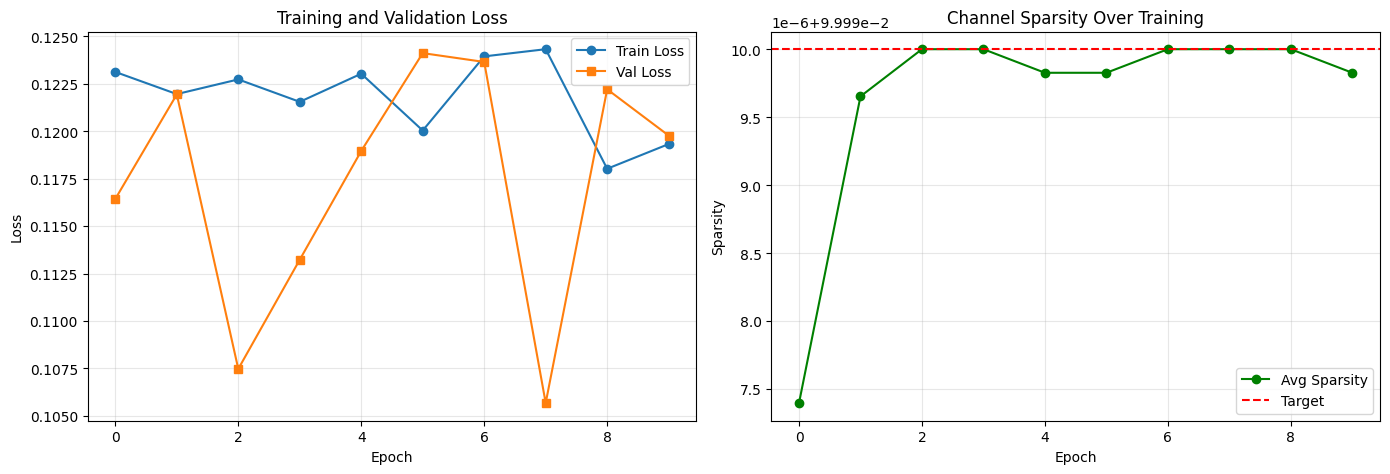

In [ ]:
# plotting training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# loss plot
ax1.plot(train_history["loss"], label="Train Loss", marker="o")
ax1.plot(val_history["loss"], label="Val Loss", marker="s")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.set_title("Training and Validation Loss")
ax1.legend()
ax1.grid(True, alpha=0.3)

# sparsity plot
ax2.plot(train_history["sparsity"], label="Avg Sparsity", marker="o", color="green")
ax2.axhline(y=config.target_sparsity, color="r", linestyle="--", label="Target")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Sparsity")
ax2.set_title("Channel Sparsity Over Training")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(Path(config.output_dir) / "training_curves.png", dpi=150, bbox_inches="tight")
plt.show()

In [ ]:
checkpoint_path = Path(config.output_dir) / "checkpoint_best.pt"
if checkpoint_path.exists():
    checkpoint = torch.load(checkpoint_path, map_location=config.device)
    unet_pruned.load_state_dict(checkpoint["model_state_dict"])
    print(f"Best checkpoint was at: Epoch {checkpoint['epoch']}")
    print(f"Val Loss: {round(checkpoint['val_loss'], 4)}")
else:
    print("no checkpoint found")

# checkpoint_path = Path(config.output_dir) / "checkpoint_best_2.pt"
# checkpoint = torch.load(checkpoint_path, map_location=config.device)
# unet_pruned.load_state_dict(checkpoint["model_state_dict"])
# unet_pruned.eval()
# print(f"✓ Loaded checkpoint from epoch {checkpoint["epoch"]}")


Best checkpoint was at: Epoch 7
Val Loss: 0.1057


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

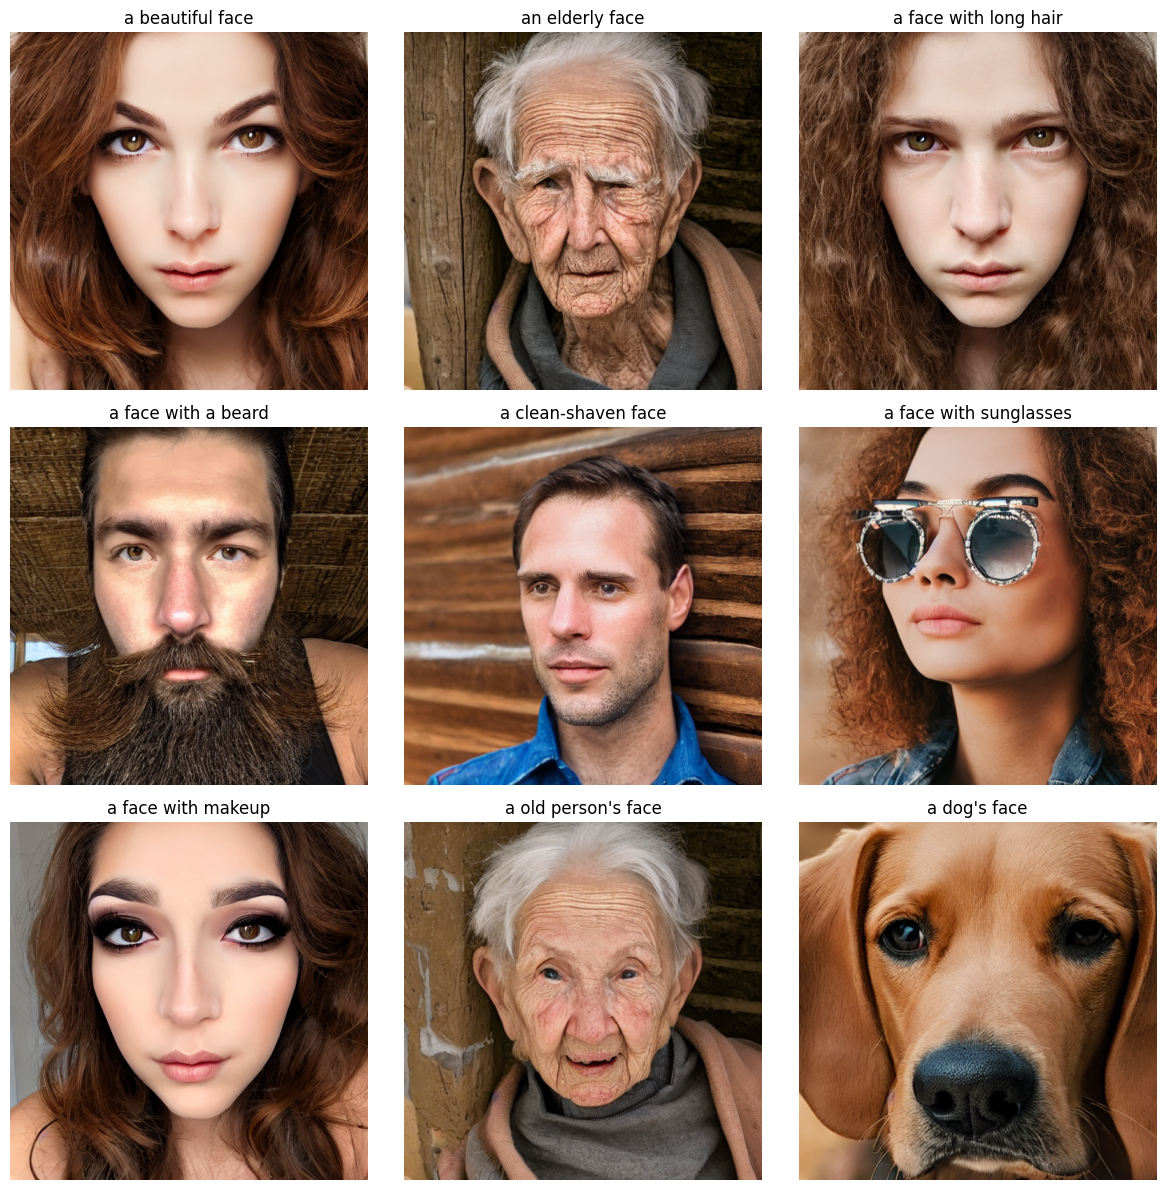

In [ ]:
# image generation

unet_pruned.enable_pruning()

pipeline.unet = unet_pruned

prompts = ["a beautiful face",
    "an elderly face",
    "a face with long hair",
    "a face with a beard",
    "a clean-shaven face",
    "a face with sunglasses",
    "a face with makeup",
    "a old person's face",
    "a dog's face"
]

fig, axes = plt.subplots(3, 3, figsize=(12, 12))
axes = axes.flatten()

for i, prompt in enumerate(prompts):
    with torch.no_grad():
        image = pipeline(
            prompt,
            num_inference_steps = 50,
            guidance_scale = 7.5,
            generator = torch.Generator(device=config.device).manual_seed(42)
        ).images[0]

    axes[i].imshow(image)
    axes[i].set_title(prompt)
    axes[i].axis("off")

plt.tight_layout()
plt.savefig(Path(config.output_dir) / "generated_samples.png", dpi=150, bbox_inches="tight")
plt.show()

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

def measure_inference_time(model, num_runs=20):
    import time

    model.eval()

    # dummy inputs - latent space
    x = torch.randn(1, 4, 64, 64).to(config.device)
    t = torch.tensor([500]).to(config.device)
    c = torch.randn(1, 77, 768).to(config.device)

    for _ in range(5):
        with torch.no_grad():
            _ = model(x, t, c).sample

    if torch.cuda.is_available():
        torch.cuda.synchronize()

    times = []
    for _ in range(num_runs):
        start = time.perf_counter()
        with torch.no_grad():
            _ = model(x, t, c).sample
        if torch.cuda.is_available():
            torch.cuda.synchronize()
        end = time.perf_counter()

        # conveting to ms
        times.append((end - start) * 1000)

    return np.mean(times), np.std(times)

# measuring baseline
unet_baseline.eval()
time_baseline, std_baseline = measure_inference_time(unet_baseline)
print(f"Baseline: {round(time_baseline, 2)} ± {round(std_baseline, 2)} ms")

# measuring - without pruning active
unet_pruned.disable_pruning()
unet_pruned.eval()
time_pruned_off, std_pruned_off = measure_inference_time(unet_pruned)
print(f"Pruned (disabled): {round(time_pruned_off, 2)} ± {round(std_pruned_off, 2)} ms")

# measuring with pruning active
unet_pruned.enable_pruning()
unet_pruned.eval()
time_pruned_on, std_pruned_on = measure_inference_time(unet_pruned)
print(f"Pruned (enabled): {round(time_pruned_on, 2)} ± {round(std_pruned_on, 2)} ms")


x = torch.randn(1, 4, 64, 64).to(config.device)
t = torch.tensor([500]).to(config.device)
c = torch.randn(1, 77, 768).to(config.device)

with torch.no_grad():
    _ = unet_pruned(x, t, c).sample
    avg_sparsity = unet_pruned.get_avg_sparsity()


speedup = time_baseline / time_pruned_on
print(f"SpeedUp: {round(speedup, 2)}x")
print("\n")

print(f"Average sparsity: {round(avg_sparsity, 2)}")
print(f"Target sparsity: {round(config.target_sparsity, 2)}")
print("\n")

# estimating efficiency gains
estimated_flops_reduction = 1 - (time_pruned_on / time_baseline)
estimated_memory_reduction = avg_sparsity * 0.8  # Conservative estimate
print(f"Estimated FLOPs reduction: ~{round(estimated_flops_reduction*100, 2)}%")
print(f"Estimated Memory reduction: ~{round(estimated_memory_reduction*100, 2)}%")

Baseline: 38.73 ± 0.03 ms
Pruned (disabled): 39.11 ± 0.27 ms
Pruned (enabled): 39.23 ± 0.07 ms
SpeedUp: 0.99x


Average sparsity: 0.1
Target sparsity: 0.1


Estimated FLOPs reduction: ~-1.29%
Estimated Memory reduction: ~8.0%


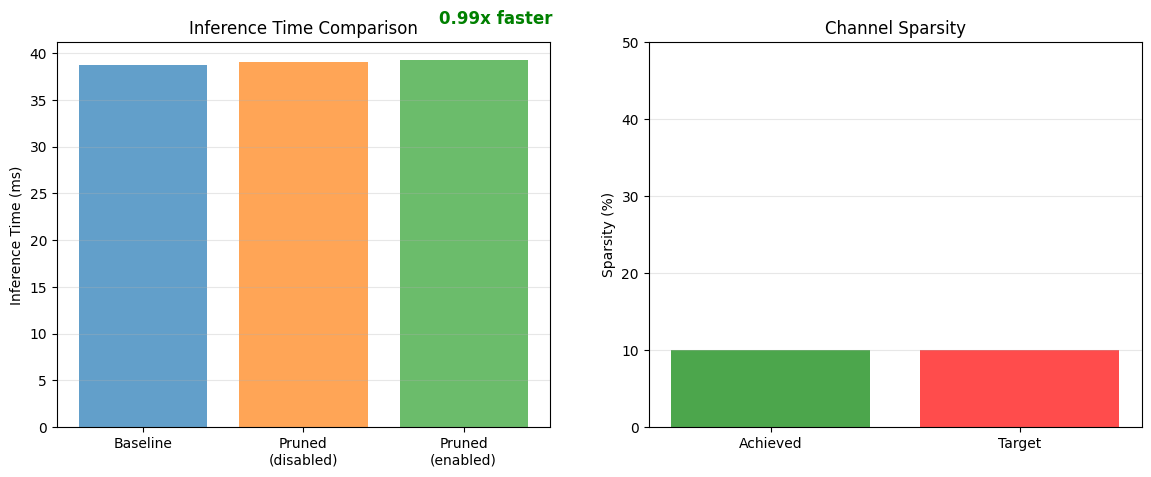

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

models = ["Baseline", "Pruned\n(disabled)", "Pruned\n(enabled)"]
times = [time_baseline, time_pruned_off, time_pruned_on]
colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]

bars = ax1.bar(models, times, color=colors, alpha=0.7)
ax1.set_ylabel("Inference Time (ms)")
ax1.set_title("Inference Time Comparison")
ax1.grid(axis="y", alpha=0.3)

# This is done because very little difference is not noticeable
ax1.text(2.2, time_pruned_on * 1.1, f"{round(speedup, 2)}x faster",
         ha="center", fontsize=12, fontweight="bold", color="green")

# sparsity visualization
ax2.bar(["Achieved", "Target"],
        [avg_sparsity * 100, config.target_sparsity * 100],
        color=["green", "red"], alpha=0.7)
ax2.set_ylabel("Sparsity (%)")
ax2.set_title("Channel Sparsity")
ax2.grid(axis="y", alpha=0.3)
ax2.set_ylim([0, 50])

plt.show()